   Model_Year   Make              Model Vehicle_Class  Engine_Size  Cylinders  \
0        2021  Acura                ILX       Compact          2.4          4   
1        2021  Acura                NSX    Two-seater          3.5          6   
2        2021  Acura         RDX SH-AWD    SUV: Small          2.0          4   
3        2021  Acura  RDX SH-AWD A-SPEC    SUV: Small          2.0          4   
4        2021  Acura         TLX SH-AWD       Compact          2.0          4   

  Transmission  Fuel_Consumption_in_City(L/100 km)  \
0          AM8                                 9.9   
1          AM9                                11.1   
2         AS10                                11.0   
3         AS10                                11.3   
4         AS10                                11.2   

   Fuel_Consumption_in_City_Hwy(L/100 km)  Fuel_Consumption_comb(L/100km)  \
0                                     7.0                             8.6   
1                                 

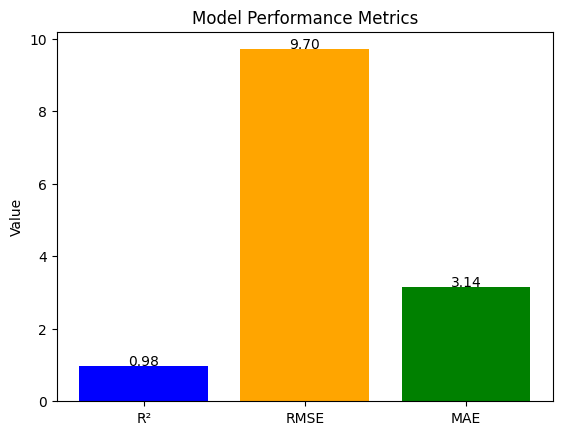

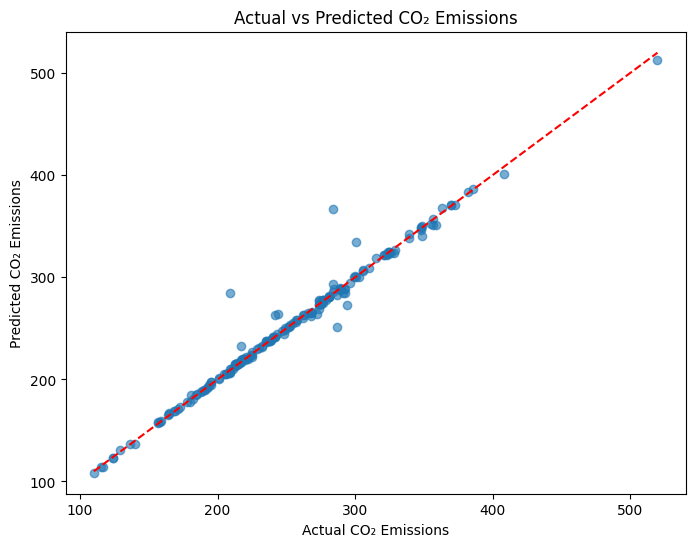

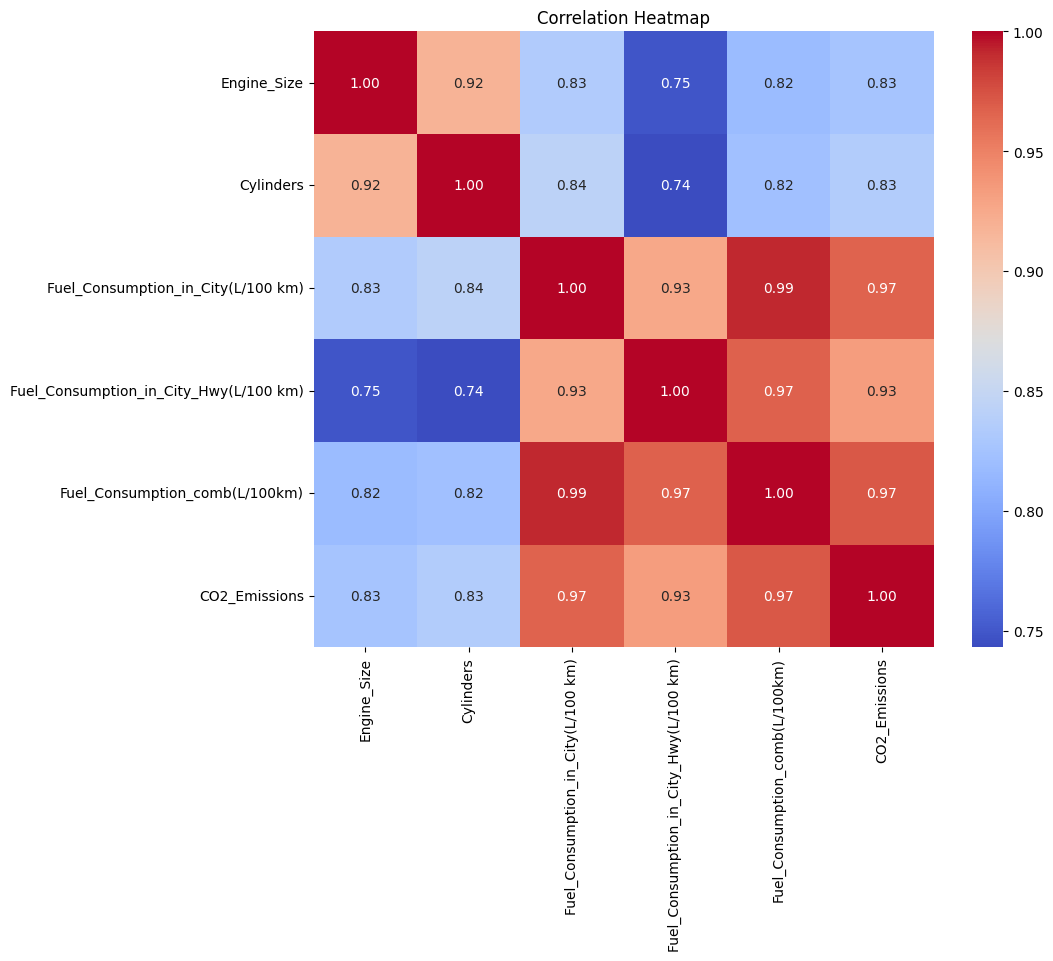

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import joblib

# Load the dataset from a CSV file
data = pd.read_csv('vehicle_emissions.csv')
print(data.head())

# Separate features (X) and target variable (y)
X = data.drop(['CO2_Emissions'], axis=1)
y = data['CO2_Emissions']

# Define numerical and categorical columns
numerical_cols = ['Engine_Size', 'Cylinders', 'Fuel_Consumption_in_City(L/100 km)',
                  'Fuel_Consumption_in_City_Hwy(L/100 km)', 'Fuel_Consumption_comb(L/100km)']
categorical_cols = ['Make', 'Model', 'Vehicle_Class', 'Transmission', 'Smog_Level']

# Pipeline for preprocessing numerical data
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for preprocessing categorical data
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols), 
    ('cat', categorical_pipeline, categorical_cols) 
])

# Final pipeline that includes preprocessing and the machine learning model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())  # Default parameters are used; can be tuned for better performance
])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Print the shape of training and testing datasets for verification
print(f'Training data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')
print(pd.DataFrame(X_train).head())

# Get the names of encoded categorical columns
# This is useful for interpreting the transformed feature set
encoded_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)
print(encoded_columns)



mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root mean squared error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"R² Score: {r2:.4f}")  # Higher is better; 1.0 indicates perfect prediction
print(f"Root Mean Squared Error: {rmse:.2f}")  # Lower is better
print(f"Mean Absolute Error: {mae:.2f}")  # Lower is better


joblib.dump(pipeline, 'vehicle_emissions_pipeline.joblib')


metrics = ['R²', 'RMSE', 'MAE']
values = [r2, rmse, mae]

plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.title('Model Performance Metrics')
plt.ylabel('Value')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()




plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Actual vs Predicted CO₂ Emissions')
plt.xlabel('Actual CO₂ Emissions')
plt.ylabel('Predicted CO₂ Emissions')
plt.show()


corr_matrix = data[numerical_cols + ['CO2_Emissions']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()